# High Level intuition:

1.   We feed input data into the neural network.
2.   The data flows from layer to layer until we have the output.
3.   Once we have the output, we can calculate the error which is a scalar.
4.   Finally we can adjust a given parameter (weight or bias) by subtracting the derivative of the error with respect to the parameter itself.

    We iterate through that process.(1->2->3->4)


 

*   The most important step is the 4th. We want to be able to have as many layers as we want, and of any type. But if we modify/add/remove one layer from the network, the output of the network is going to change, which is going to change the error, which is going to change the derivative of the error with respect to the parameters.
*   We need to be able to compute the derivatives regardless of the network architecture, regardless of the activation functions, regardless of the loss we use.



In [13]:
import numpy as np

# What every layer should implement:
*    Every layer that we might create (fully connected, convolutional, maxpooling, dropout, etc.) have at least 2 things in common: **input** and **output** data.
 
*   **Forward propagation**: The output of one layer is the input of the next one. This is called forward propagation. Essentially, we give the input data to the first layer, then the output of every layer becomes the input of the next layer until we reach the end of the network.
 
*   **Backward Propagation**: By comparing the result of the network (Y) with the desired output (let’s say Y*), we can calculate en error E. The goal is to minimize that error by changing the parameters in the network. That is backward propagation (backpropagation).












# **Forward Propagation**
The value of each output neuron can be calculated as the following :

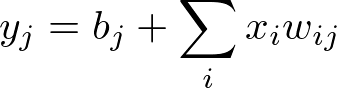

With matrices, we can compute this formula for every output neuron in one shot using a dot product :

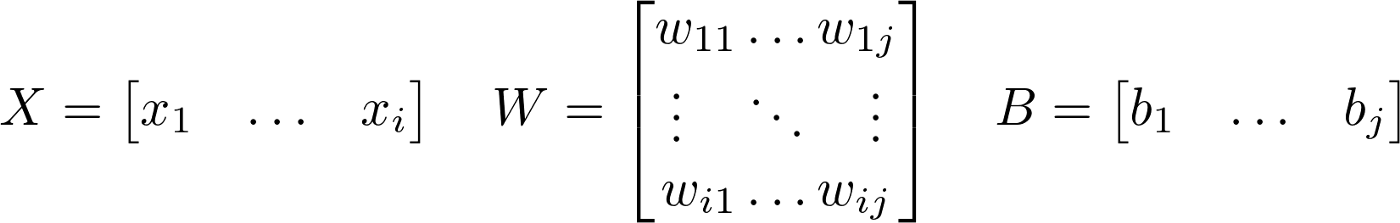

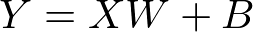


We’re done with the forward pass. Now let’s do the backward pass of the FC layer.


# **Backward Propagation**
As we said, suppose we have a matrix containing the derivative of the error with respect to that layer’s output (∂E/∂Y). We need :

* The derivative of the error with respect to the parameters (∂E/∂W, ∂E/∂B)
* The derivative of the error with respect to the input (∂E/∂X)

Let's calculate ∂E/∂W. This matrix should be the same size as W itself : [i X j] where i is the number of input neurons and j the number of output neurons. We need one gradient for every weight :

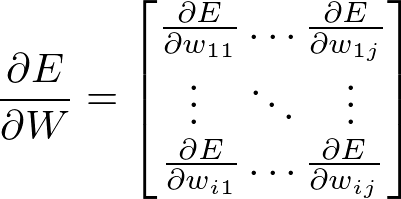

Using the chain rule, we can write :

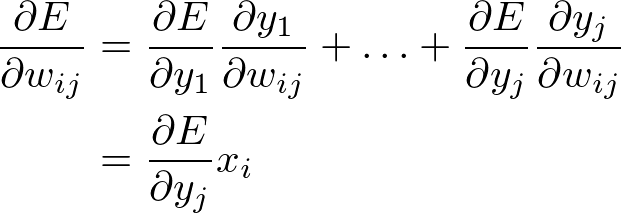


(∂yk/∂Wij) will be zero for all the values of i,j,k except when k = j
In that case yj = wij*xi + bj => (∂yj/∂Wij) = xi
Therefore,

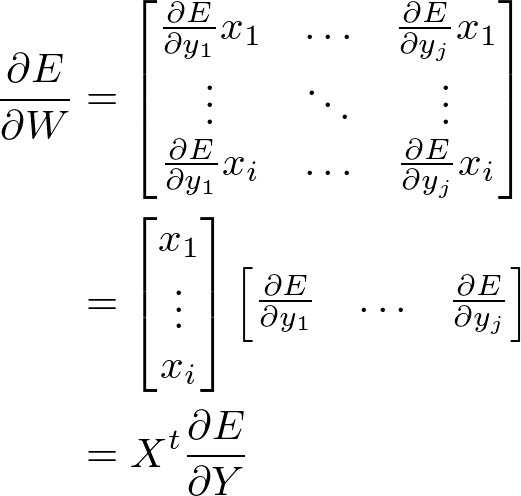

That’s it we have the first formula to update the weights! Now let's calculate ∂E/∂B.

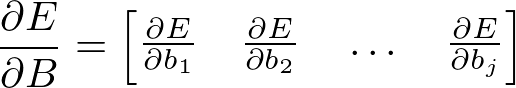

Again ∂E/∂B needs to be of the same size as B itself, one gradient per bias. We can use the chain rule again :

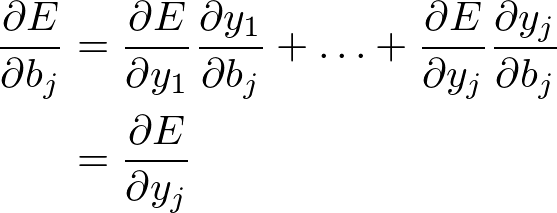

**Conclusion:**

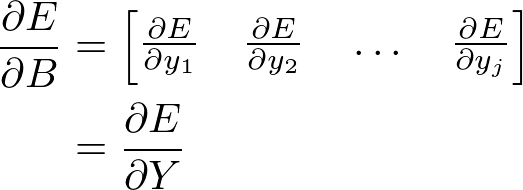

Now that we have ∂E/∂W and ∂E/∂B, we are left with ∂E/∂X which is very important as it will “act” as ∂E/∂Y for the layer before that one.

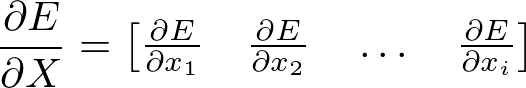

Again, using the chain rule,

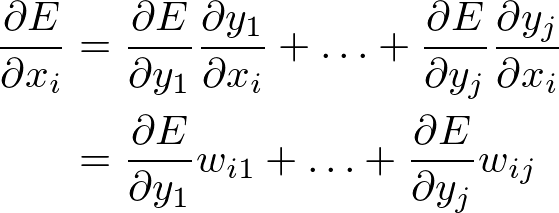

Finally, we can write the whole matrix :

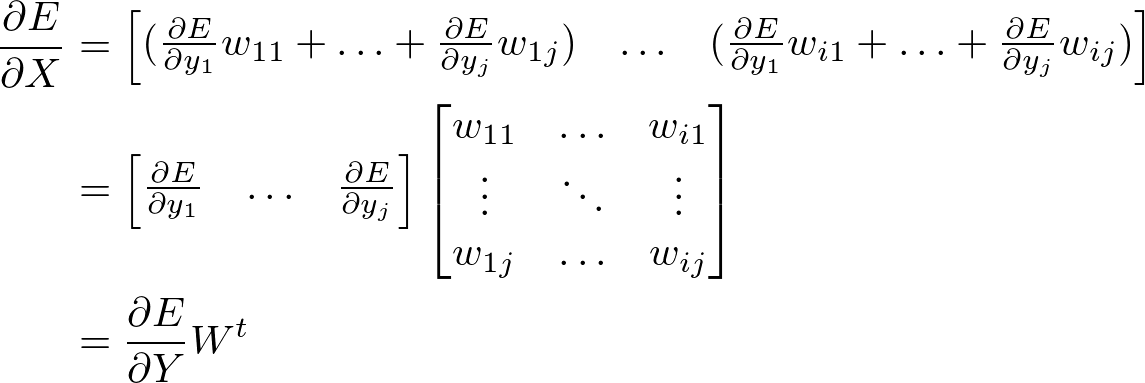

That’s it! We have the three formulas we needed for the FC layer!

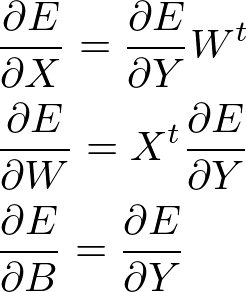

In [14]:
class FCLayer:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(input_size, output_size) / np.sqrt(input_size + output_size)
        self.bias = np.random.randn(1, output_size) / np.sqrt(input_size + output_size)

    def forward(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.bias

    def backward(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # bias_error = output_error
        
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

# **Activation Layer**

We will call f and f' the activation function and its derivative respectively.
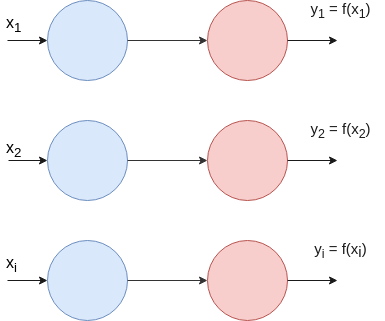

**Forward Propagation**
As you will see, it is quite straightforward. For a given input X , the output is simply the activation function applied to every element of X . Which means input and output have the same dimensions.

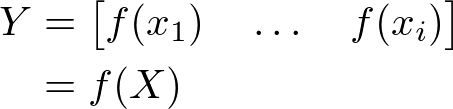

**Backward Propagation**
Given ∂E/∂Y, we want to calculate ∂E/∂X.

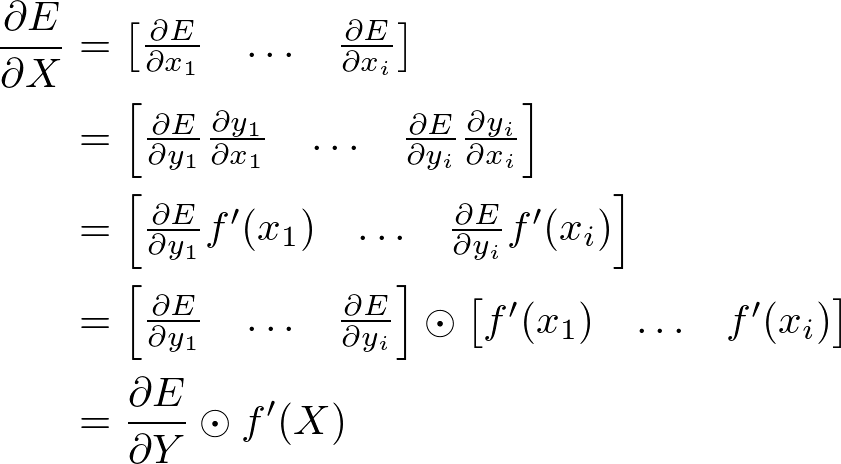

**here we are using an element-wise multiplication between the two matrices (whereas in the formulas above, it was a dot product).**

In [15]:
class ActivationLayer:
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime
    
    def forward(self, input):
        self.input = input
        return self.activation(input)
    
    def backward(self, output_error, learning_rate):
        #IMP NOTE : Element wise multiplication
        return output_error * self.activation_prime(self.input)

In [16]:
class FlattenLayer:
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def forward(self, input):
        return np.reshape(input, (1, -1))
    
    def backward(self, output_error, learning_rate):
        return np.reshape(output_error, self.input_shape)

In [17]:
# bonus
class SoftmaxLayer:
    def __init__(self, input_size):
        self.input_size = input_size
    
    def forward(self, input):
        self.input = input
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_error, learning_rate):
        input_error = np.zeros(output_error.shape)
        out = np.tile(self.output.T, self.input_size)
        return self.output * np.dot(output_error, np.identity(self.input_size) - out)

**some activation functions and their derivatives**

These will be used later to create an ActivationLayer.

In [18]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return np.exp(-x) / (1 + np.exp(-x))**2

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1 - np.tanh(x)**2

def relu(x):
    return np.maximum(x, 0)

def relu_prime(x):
    return np.array(x >= 0).astype('int')

**Loss Function**


Until now, for a given layer, we supposed that ∂E/∂Y was given (by the next layer). But what happens to the last layer? How does it get ∂E/∂Y? We simply give it manually, and it depends on how we define the error.

The error of the network, which measures how good or bad the network did for a given input data, is defined by you. There are many ways to define the error, and one of the most known is called MSE — Mean Squared Error.

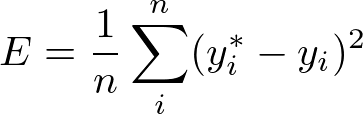


Where y* and y denotes desired output and actual output respectively. You can think of the loss as a last layer which takes all the output neurons and squashes them into one single neuron. What we need now, as for every other layer, is to define ∂E/∂Y. Except now, we finally reached E !

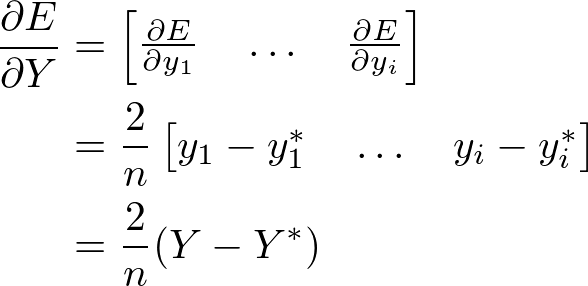

Some cost functions :

In [19]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_pred.size

def sse(y_true, y_pred):
    return 0.5 * np.sum(np.power(y_true - y_pred, 2))

def sse_prime(y_true, y_pred):
    return y_pred - y_true

**Network Object**


Almost done ! We are going to make a Network object to create neural networks very easily akin the first picture !



**STEP 1:** 

Import dataset and split it into training and testing dataset

In [20]:
from keras.datasets import mnist
from keras.utils import np_utils

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_train /= 255
y_train = np_utils.to_categorical(y_train)
x_train = x_train[0:1000]
y_train = y_train[0:1000]

x_test = x_test.astype('float32')
x_test /= 255
y_test = np_utils.to_categorical(y_test)

11501568/11490434 [==============================] - 0s 0us/step


**STEP 2:**

Create a network with desired dimensions

In [21]:
network = [
    FlattenLayer(input_shape=(28, 28)),
    FCLayer(28 * 28, 128),
    ActivationLayer(relu, relu_prime),
    FCLayer(128, 10),
    SoftmaxLayer(10)
]

epochs = 40
learning_rate = 0.1

# training
for epoch in range(epochs):
    error = 0
    for x, y_true in zip(x_train, y_train):
        # forward
        output = x
        for layer in network:
            output = layer.forward(output)
        
        # error (display purpose only)
        error += mse(y_true, output)

        # backward
        output_error = mse_prime(y_true, output)
        for layer in reversed(network):
            output_error = layer.backward(output_error, learning_rate)
    
    error /= len(x_train)
    print('%d/%d, error=%f' % (epoch + 1, epochs, error))

1/40, error=0.071260
2/40, error=0.033020
3/40, error=0.021745
4/40, error=0.016797
5/40, error=0.013764
6/40, error=0.011561
7/40, error=0.009758
8/40, error=0.008436
9/40, error=0.007386
10/40, error=0.006566
11/40, error=0.005892
12/40, error=0.005330
13/40, error=0.004836
14/40, error=0.004430
15/40, error=0.004110
16/40, error=0.003830
17/40, error=0.003582
18/40, error=0.003354
19/40, error=0.003140
20/40, error=0.002932
21/40, error=0.002747
22/40, error=0.002593
23/40, error=0.002465
24/40, error=0.002360
25/40, error=0.002267
26/40, error=0.002173
27/40, error=0.002066
28/40, error=0.001923
29/40, error=0.001787
30/40, error=0.001706
31/40, error=0.001644
32/40, error=0.001581
33/40, error=0.001530
34/40, error=0.001495
35/40, error=0.001467
36/40, error=0.001442
37/40, error=0.001417
38/40, error=0.001389
39/40, error=0.001355
40/40, error=0.001320


**STEP 3:**

Make Predictions and calculate accuracy of the model

In [22]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

ratio = sum([np.argmax(y) == np.argmax(predict(network, x)) for x, y in zip(x_test, y_test)]) / len(x_test)
error = sum([mse(y, predict(network, x)) for x, y in zip(x_test, y_test)]) / len(x_test)
print('ratio: %.2f' % ratio)
print('mse: %.4f' % error)

ratio: 0.88
mse: 0.0188


**STEP 4:**

Visualize the model predictions

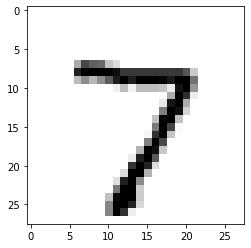

pred: 7, prob: 1.00, true: 7


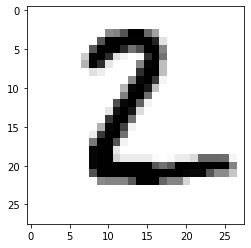

pred: 6, prob: 0.73, true: 2


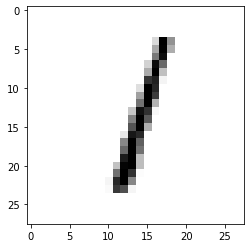

pred: 1, prob: 0.99, true: 1


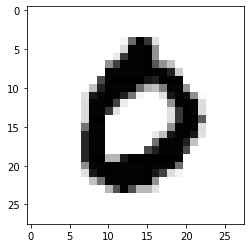

pred: 0, prob: 0.99, true: 0


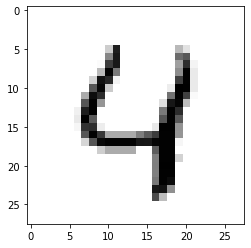

pred: 4, prob: 0.97, true: 4


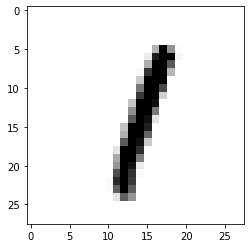

pred: 1, prob: 0.98, true: 1


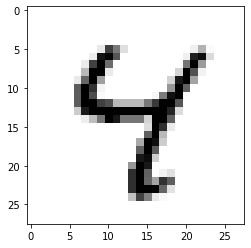

pred: 4, prob: 0.99, true: 4


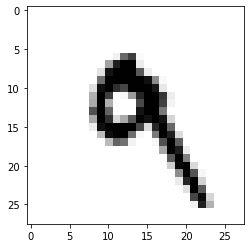

pred: 9, prob: 0.99, true: 9


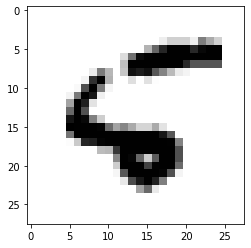

pred: 2, prob: 0.92, true: 5


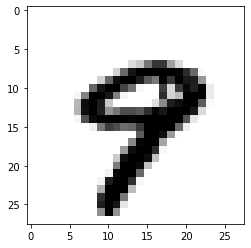

pred: 9, prob: 0.89, true: 9


In [23]:
import matplotlib.pyplot as plt

samples = 10
for test, true in zip(x_test[:samples], y_test[:samples]):
    image = np.reshape(test, (28, 28))
    plt.imshow(image, cmap='binary')
    plt.show()
    pred = predict(network, test)[0]
    idx = np.argmax(pred)
    idx_true = np.argmax(true)
    print('pred: %s, prob: %.2f, true: %d' % (idx, pred[idx], idx_true))

Reference: https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65